<a href="https://colab.research.google.com/github/FabriceBeaumont/1-MA-INF_2314_IPSA_Repo/blob/main/Code/Exercise5/SolutionsOfSheet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IPSA 2021 - Exercise 5 - Image filtering

## 0 - Practical Advice

In [ ]:
import imageio 
import numpy as np
import numpy.random as rnd
from numpy import exp, sin, cos
import scipy.signal as sig

import scipy.ndimage as img
import scipy.interpolate as ipl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6]
import timeit, functools

In [ ]:
def imageScaleRange(f, vmin=0, vmax=255):
    """Stretches the intensity values of a given image array f 
    such that they cover the whole range from 0 to 255"""
    return np.interp(f, (f.min(), f.max()), (vmin, vmax))

def imageRead(imgname, pilmode ='L', arrtype=float):
    """
    Read an image file into a numpy array

    imgname: str
        name of image file to be read
    pilmode: str
        for luminance / intesity images use ’L’
        for RGB color images use ’RGB’
    
    arrtype: numpy dtype
        use np.float, np.uint8, ...
    """
    return imageio.imread(imgname, pilmode=pilmode).astype(arrtype)

def imageWrite(arrF, imgname, arrtype=np.uint8):
    """
    Write a numpy array as an image file 
    the file type is inferred from the suffix of parameter imgname, e.g. ’.png’
    arrF: array_like
        array to be written
    imgname: str
        name of image file to be written
    arrtype: numpy dtype
        use np.uint8, ...
    """
    imageio.imwrite(imgname, arrF.astype(arrtype))

In [ ]:
def writeFigure(fig, fname):
    fmt = fname.split('.')[-1]
    fig.savefig(fname, facecolor=fig.get_facecolor(), edgecolor='w',
                papertype='letter', format=fmt, transparent=False,
                bbox_inches='tight', pad_inches=0)

def plotFcts(x, fs,
             labs=None, lfs='x-small',
             xtcs=None, ytcs=None,
             lims=None, fname=None, title=None):

    # Initialize figure and axes.
    fig = plt.figure()
    axs = fig.add_subplot(211, facecolor='w')

    # Nicer way of showing coordinate axes.
    for pos in ['left','bottom']:
        axs.spines[pos].set_position('zero')
    for pos in ['right','top']:
        axs.spines[pos].set_visible(False)
        
    # Plot the function.
    for f in fs:
        axs.plot(x, f, '-', alpha=0.75)

    # Plot the legend.
    if labs is not None:
        axs.legend(labs, loc="upper right", fontsize=lfs,
                   facecolor='#e0e0e0', edgecolor='k', fancybox=False)

    if xtcs is not None: axs.set_xticks(xtcs)
    if ytcs is not None: axs.set_yticks(ytcs)
    
    if lims is not None:
        axs.set_xlim(lims[0], lims[1])
        axs.set_ylim(lims[2], lims[3])
        
    if title:
        plt.title(title)
        
        
    # Show figure on screen or write it to disc.
    plt.show() if fname is None else writeFigure(fig, fname)
    plt.close()

def plotShapeFct(Z, closed=True, lw=1, ms=2, mew=0, al=0.75, fname=None, title=None):
    # Initialize figure and axes.
    fig = plt.figure()
    axs = fig.add_subplot('111', facecolor='w')
    axs.set_aspect(aspect='equal')
    
    # Nicer way of showing coordinate axes.
    for pos in ['left','bottom']:
        axs.spines[pos].set_position('zero')
    for pos in ['right','top']:
        axs.spines[pos].set_visible(False)
        

    if closed:
        Z = np.hstack((Z, Z[0]))
        
    X = Z.real
    Y = Z.imag

    # Plot dottet or as line - depending on the 'closed'-flag.
    if closed:
        axs.plot(X, Y, '-', lw=lw, alpha=al)
    else:
        axs.plot(X, Y, 'o', ms=ms, mew=mew, alpha=al)

    xmin, xmax = min(-1, np.min(X)-1), np.max(X)+1
    ymin, ymax = min(-1, np.min(Y)-1), np.max(Y)+1
    
    axs.set_xlim(xmin, xmax)
    axs.set_ylim(ymin, ymax)

    if title:
        plt.title(title)

    # Show figure on screen or write it to disc.
    plt.show() if fname is None else writeFigure(fig, fname)
    plt.close()

    return fig

In [ ]:
def plotImagesAsRow(images, titles=None):
    # Display the images side by side.
    fig, axs = plt.subplots(1, len(images), figsize=(20,20))

    for i, image in enumerate(images):
        ax = axs[i]
        ax.imshow(image, cmap='gray') 
        if titles is not None: 
            ax.set_title(titles[i], fontsize=30)
        
        ax.set_xticklabels([]); ax.set_yticklabels([])    
        fig.tight_layout()

    plt.show()

## 1 - Mean filtering in $\mathcal{O}(1)$

In the lecture, we discussed the idea of mean filtering. The following function wraps the scipy `ndimage` function `uniform filter` which implements a mean filter:

In [ ]:
def meanFilterV1(arrf, m):
    return img.uniform_filter(arrf, (m,m), mode='constant', cval=0.0)

Read the image `portrait.png` into a `numpy` array `arrf`, set the size of the filter mask to $m=5$, and run `meanFilterV1` to produce a smoothed image array `arrg`.

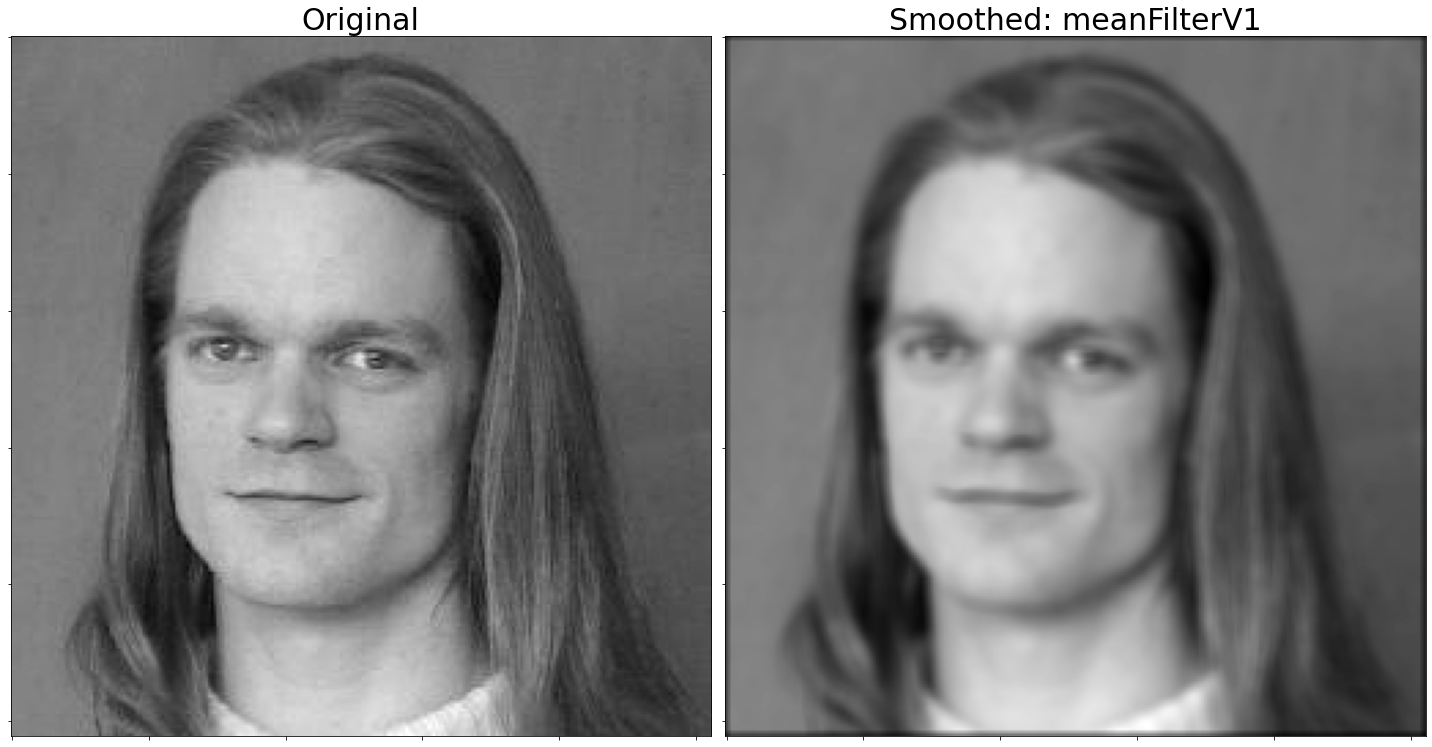

In [ ]:
arrf = imageRead('portrait.png')
m = 5
# Store the original image and the smoothed one in a list.
images = [arrf, meanFilterV1(arrf, m)]
# Set titles.
titles = ['Original', 'Smoothed: meanFilterV1']

# Display the images side by side.
plotImagesAsRow(images, titles)

In the lecture, we also discussed the idea of (per pixel) $\mathcal{O}(1)$ mean filtering
based on integral images. The following function realizes this (in a rather naı̈ve manner from the point of view of efficient array computation):

In [ ]:
def meanFilterV2(arrf, m):
    """
    Naive (wrt to efficient array computation) implementation of a per pixel
    (O(1)) mean filtering on integral images.
    """
    M, N = arrf.shape
    # Pad input image with zeros and compute integral image.
    arrF = np.pad(arrf, [m//2,m//2], 'constant', constant_values=[0,0])
    arrC = np.cumsum(np.cumsum(arrF, axis=1), axis=0)
    arrg = np.zeros((M,N))
    # Iterate over all pixels
    for i in range(M):
        for j in range(N):
            arrg[i,j] = arrC[i+m-1,j+m-1]
            if i > 0:
                arrg[i,j] -= arrC[i-1,j+m-1]
            if j > 0:
                arrg[i,j] -= arrC[i+m-1,j-1]
            if i > 0 and j > 0:
                arrg[i,j] += arrC[i-1,j-1]
    return arrg / m**2

To convince yourself that the idea works, once again consider `arrf`, set the size of the filter mask to $m=5$, and run `meanFilterV2` to produce a smoothed image array `arrg`.

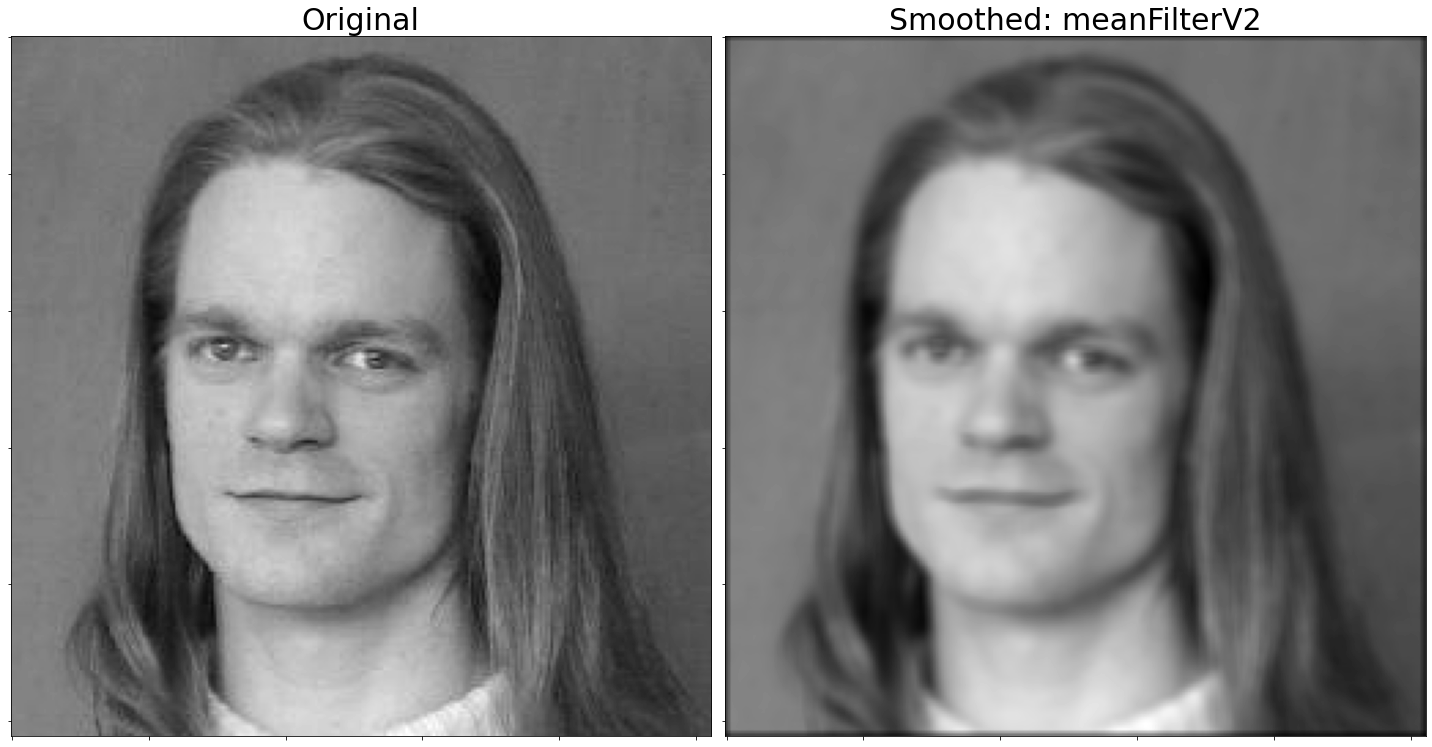

In [ ]:
arrf = imageRead('portrait.png')
m = 5
# Store the original image and the smoothed one in a list.
images = [arrf, meanFilterV2(arrf, m)]
# Set titles.
titles = ['Original', 'Smoothed: meanFilterV2']

# Display the images side by side.
plotImagesAsRow(images, titles)

The above implementation of the integral image based mean filter is naı̈ve, because it involves nested python for-loops. By now, you should be able to see that these for-loops can be avoided by making use of numpy’s array processing capabilities.

Implement a for loop free version of the integral image based mean filter. That is, appropriately complete the following function definition:

    def meanFilterV3(arrf, m):
        # pad input image with zeros and compute integral image
        arrF = np.pad(arrf, [m//2,m//2], ’constant’, constant_values=[0,0])
        arrC = np.cumsum(np.cumsum(arrF, axis=1), axis=0)
        ...

In [ ]:
def meanFilterV3(arrf, m):
    """
    For-loop-free implementation of a per pixel (O(1)) mean filtering on integral images.
    """
    # Pad input image with zeros and compute integral image.
    arrF = np.pad(arrf, [m//2,m//2], 'constant', constant_values=[0,0])
    arrC = np.cumsum(np.cumsum(arrF, axis=1), axis=0)

    arrg = np.copy(arrC[m-1:, m-1:])
    arrg[1:, :] -= arrC[:-m , m-1:]
    arrg[ :,1:] -= arrC[m-1:, :-m]
    arrg[1:,1:] += arrC[:-m , :-m]

    return arrg / m**2

To verify that your code works, once again consider `arrf`, set the size of the filter mask to $m=5$, and run `meanFilterV3` to produce a smoothed image array `arrg`.

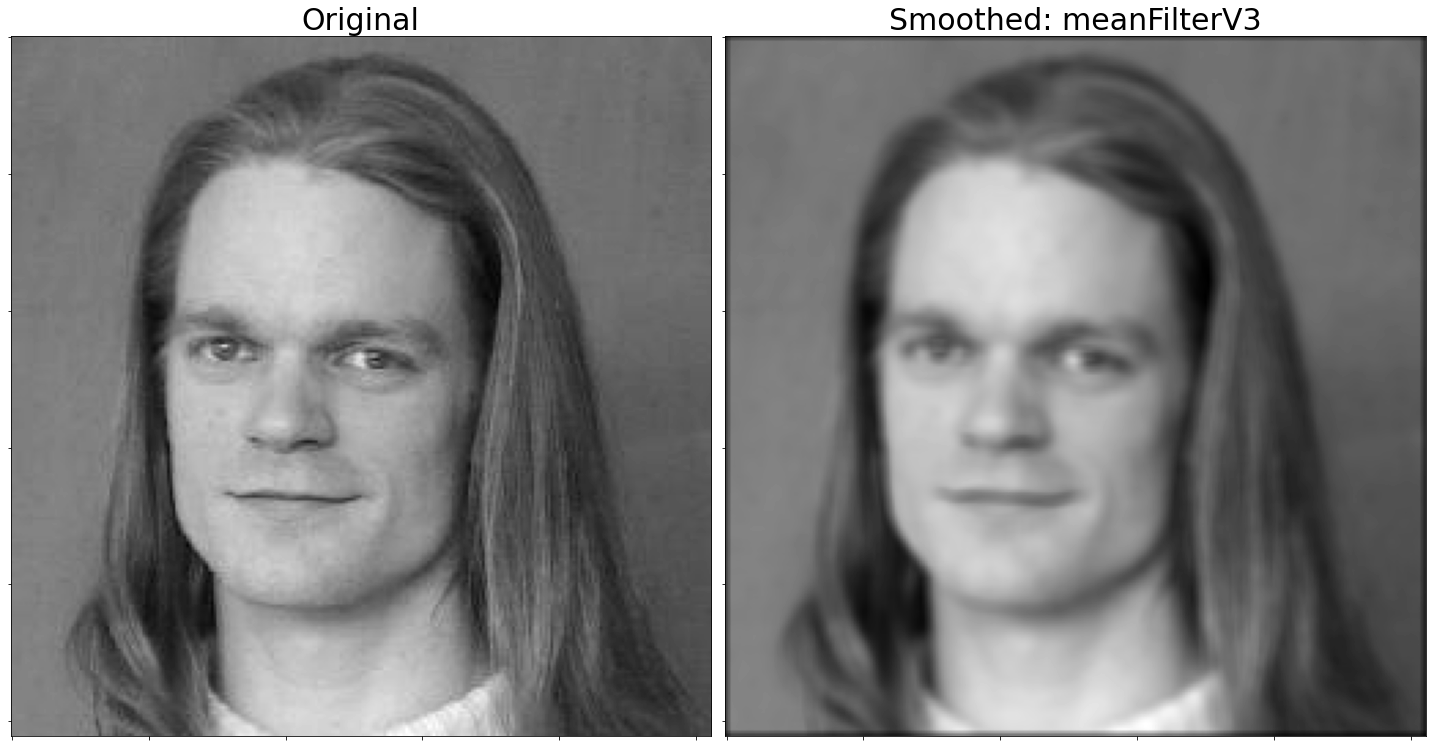

In [ ]:
arrf = imageRead('portrait.png')
m = 5
# Store the original image and the smoothed one in a list.
images = [arrf, meanFilterV3(arrf, m)]
# Set titles.
titles = ['Original', 'Smoothed: meanFilterV3']

# Display the images side by side.
plotImagesAsRow(images, titles)

### Summary of the three filtering functions in task 1

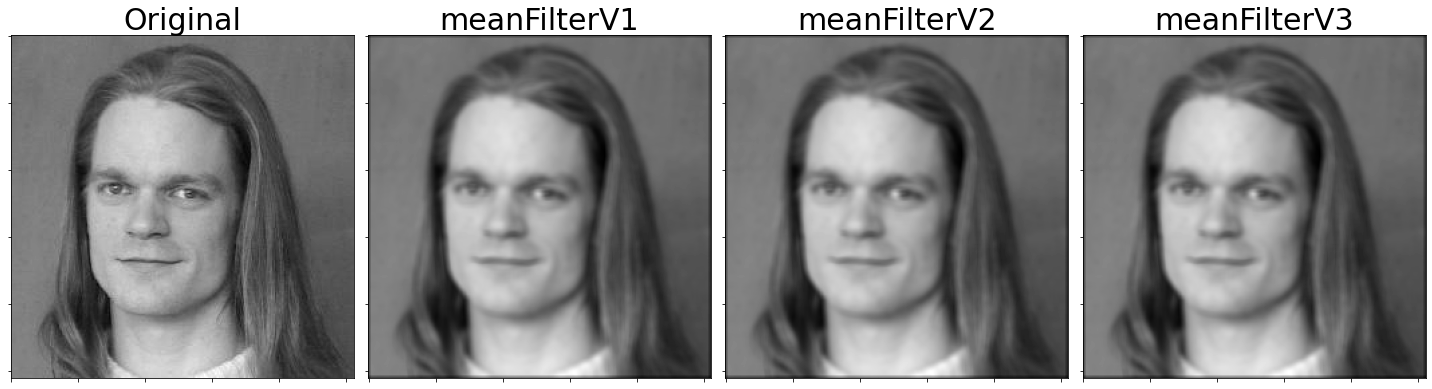

In [ ]:
arrf = imageRead('portrait.png')
m = 5
# Store the original image and the smoothed ones in a list.
images = [arrf]
titles = ['Original']
functions = [meanFilterV1, meanFilterV2, meanFilterV3]
for function in functions:
    images.append(function(arrf, m))
    titles.append(function.__name__)

# Display the images side by side.
plotImagesAsRow(images, titles)

## 2 - Runtimes of efficient mean filters

n this task, you are supposed to empirically analyze the runtimes of the above functions. Use what you learned in exercises 1 and 2 to perform
corresponding runtime measurements and consider the following experimental setting:

Perform your measurements for image portrait.png, consider mask sizes $m\in \{5, 11, 23, 47\}$, and determine the average runtimes of functions `meanFilterV1` and `meanFilterV3`. Enter your results (rounded to five decimal places) into the following table:

<table>
    <thead>      
       <tr>
        <th>Name</th>
        <th colspan="4"><center>Filter mask sizes and runtimes [ms]</center></th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td></td>
        <td>m=5</td>
        <td>m=11</td>        
        <td>m=23</td>
        <td>m=47</td>
      </tr>
      <tr>
        <td>meanFilterV1</td>
        <td>0.75</td>
        <td>0.74</td>        
        <td>0.75</td>
        <td>0.77</td>
      </tr>
      <tr>
        <td>meanFilterV3</td>
        <td>1.32</td>
        <td>1.33</td>        
        <td>1.41</td>
        <td>1.54</td>
      </tr>
    </tbody>
  </table>

Discuss what you observe! What do your runtime measurements tell you about the way the scipy developers have apparently implemented the function `uniform filter`?

In [ ]:
arrf = imageRead('portrait.png')
mask_sizes = [5, 11, 23, 47]

nRep =   3
nRun = 100
functions = [meanFilterV1, meanFilterV3]

for m in [5, 11, 23, 47]:
    for function in functions:
        ts = timeit.Timer(functools.partial(function,arrf,m)).repeat(nRep, nRun)
        duration = np.round((min(ts) / nRun), 5)
        print(f"{function.__name__}(arrf, {m}) took\t{duration}\tsec.")
    print()

meanFilterV1(arrf, 5) took	0.00074	sec.
meanFilterV3(arrf, 5) took	0.00129	sec.

meanFilterV1(arrf, 11) took	0.00074	sec.
meanFilterV3(arrf, 11) took	0.00136	sec.

meanFilterV1(arrf, 23) took	0.00075	sec.
meanFilterV3(arrf, 23) took	0.00138	sec.

meanFilterV1(arrf, 47) took	0.00077	sec.
meanFilterV3(arrf, 47) took	0.00153	sec.



The runtimes of `meanFilterV1` with the `uniform_filter` function show almost no increase in runtime with increased mask size. One my suspect that the runntimes are in $\mathcal{O}(1)$. And `meanFilterV1` makes use of further optimizations.

### Bonus task (for those who are patient)

Should you still not believe that, when it comes to array processing, python for loops have to be avoided at all costs, then consider the same setting as above but evaluate the average runtimes of function `meanFilterV2` and enter your results into the following table:

In [ ]:
arrf = imageRead('portrait.png')
mask_sizes = [5, 11, 23, 47]

nRep =   3
nRun = 100
functions = [meanFilterV2]

for m in [5, 11, 23, 47]:
    for function in functions:
        ts = timeit.Timer(functools.partial(function,arrf,m)).repeat(nRep, nRun)
        duration = np.round((min(ts) / nRun), 5)
        print(f"{function.__name__}(arrf, {m}) took\t{duration}\tsec.")

meanFilterV2(arrf, 5) took	0.1673	sec.
meanFilterV2(arrf, 11) took	0.16484	sec.
meanFilterV2(arrf, 23) took	0.16387	sec.
meanFilterV2(arrf, 47) took	0.16506	sec.


One result was:

    meanFilterV2(arrf, 5)  took	0.1673	 sec.
    meanFilterV2(arrf, 11) took	0.16484	sec.
    meanFilterV2(arrf, 23) took	0.16387	sec.
    meanFilterV2(arrf, 47) took	0.16506	sec.

## 3 - Bilateral filtering

Implement a bilateral filter
$$ h[x,y] = \gamma[x,y] \sum\limits_{u=-\frac{m}{2}}^{\frac{m}{2}} \sum\limits_{v=-\frac{m}{2}}^{\frac{m}{2}} g_\rho\big[ f[x-u,y-c]-f[x,y] \big] \cdot G_\sigma[u,v] \cdot f[x-u,y-v]$$

where 
- $m=\lceil 2.575 \cdot \sigma\rceil \cdot 2+ 1 $
- $ g_\rho[z] = \exp\Big( - \frac{z^2}{2\rho^2} \Big) $
- $ G_\sigma[u,v] = \exp\Big( - \frac{u^2+v^2}{2\sigma^2} \Big) $
- $\gamma[x,y] = \Big( \sum\limits_{u=-\frac{m}{2}}^{\frac{m}{2}} \sum\limits_{v=-\frac{m}{2}}^{\frac{m}{2}} g_\rho\big[ f[x-u,y-c]-f[x,y] \big] \cdot G_\sigma[u,v] \Big)^{-1}$

**Note**: Efficient implementations of this filter are possible but tricky, see for
instance
- ["Gaussian KD-trees for Fast High-dimensinal Filtering](https://dl.acm.org/doi/abs/10.1145/1576246.1531327?casa_token=MOFXErAnfFQAAAAA:SRYOgFbSe5bDV-L2wxfp1aN4RV6o0BHqbxftLUvVGZ6Z-jylo3MywCUMp7nATH3SiET3bb497HZXCQ)
- ["A Low-Memory,
Straightforward and Fast Bilateral Filter Through Subsampling in Spa-
tial Domain”](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-8659.2011.02078.x?casa_token=IK9pkit30ygAAAAA:g6HtxyY0gtLGs_rEq4qGfvAcPx5o8i8eAASk4Tec2AlqCVQYFjGOXg--yNne8DCfRQQNwzI0h1tlO0Bp)

The methods used in papers like these go beyond what we can study in this course.

**Note**: At first sight, an implementation of the bilateral filter seems to require many nested for loops. 
When working with languages such as C, FORTRAN, or Julia, this will be no issue. Yet, in python /`numpy`, this will kill performance. 
However, clever use of numpy’s inbuilt array processing capabilities allows for avoiding most of these explicit loops. In fact, if we were willing to accept barely readable code, all of them could be avoided. Since this would be overkill, a suggestion is to try to come with an implementation that involves as few for loops as reasonably possible.

In [ ]:
def bilateral_filter(arrf, rho=10., sig=2.0):
    M, N = arrf.shape
    arrh = np.zeros((M,N))
    
    m = int(np.ceil(sig * 2.575) * 2 + 1)
    z = m//2

    arrF = np.pad(arrf, z, mode='constant')

    Gsig = np.outer(np.exp(-0.5 * (np.arange(m)-z)**2 / sig**2),
                    np.exp(-0.5 * (np.arange(m)-z)**2 / sig**2))

    for y in range(M):
        for x in range(N):
            i, j = y+z, x+z
            
            arrN = arrF[i-z:i+z+1,j-z:j+z+1]
            grho = np.exp(-0.5 * (arrN - arrF[i,j])**2 / rho**2)

            arrH  = grho * Gsig
            arrH /= arrH.sum()

            arrh[y,x] = np.sum(arrH * arrN)

    return arrh

Run your implementation on image `portrait.png` using the parameters $\sigma\in\{3, 6, 12\}$ and $\rho\in\{10, 20, 40\}$.

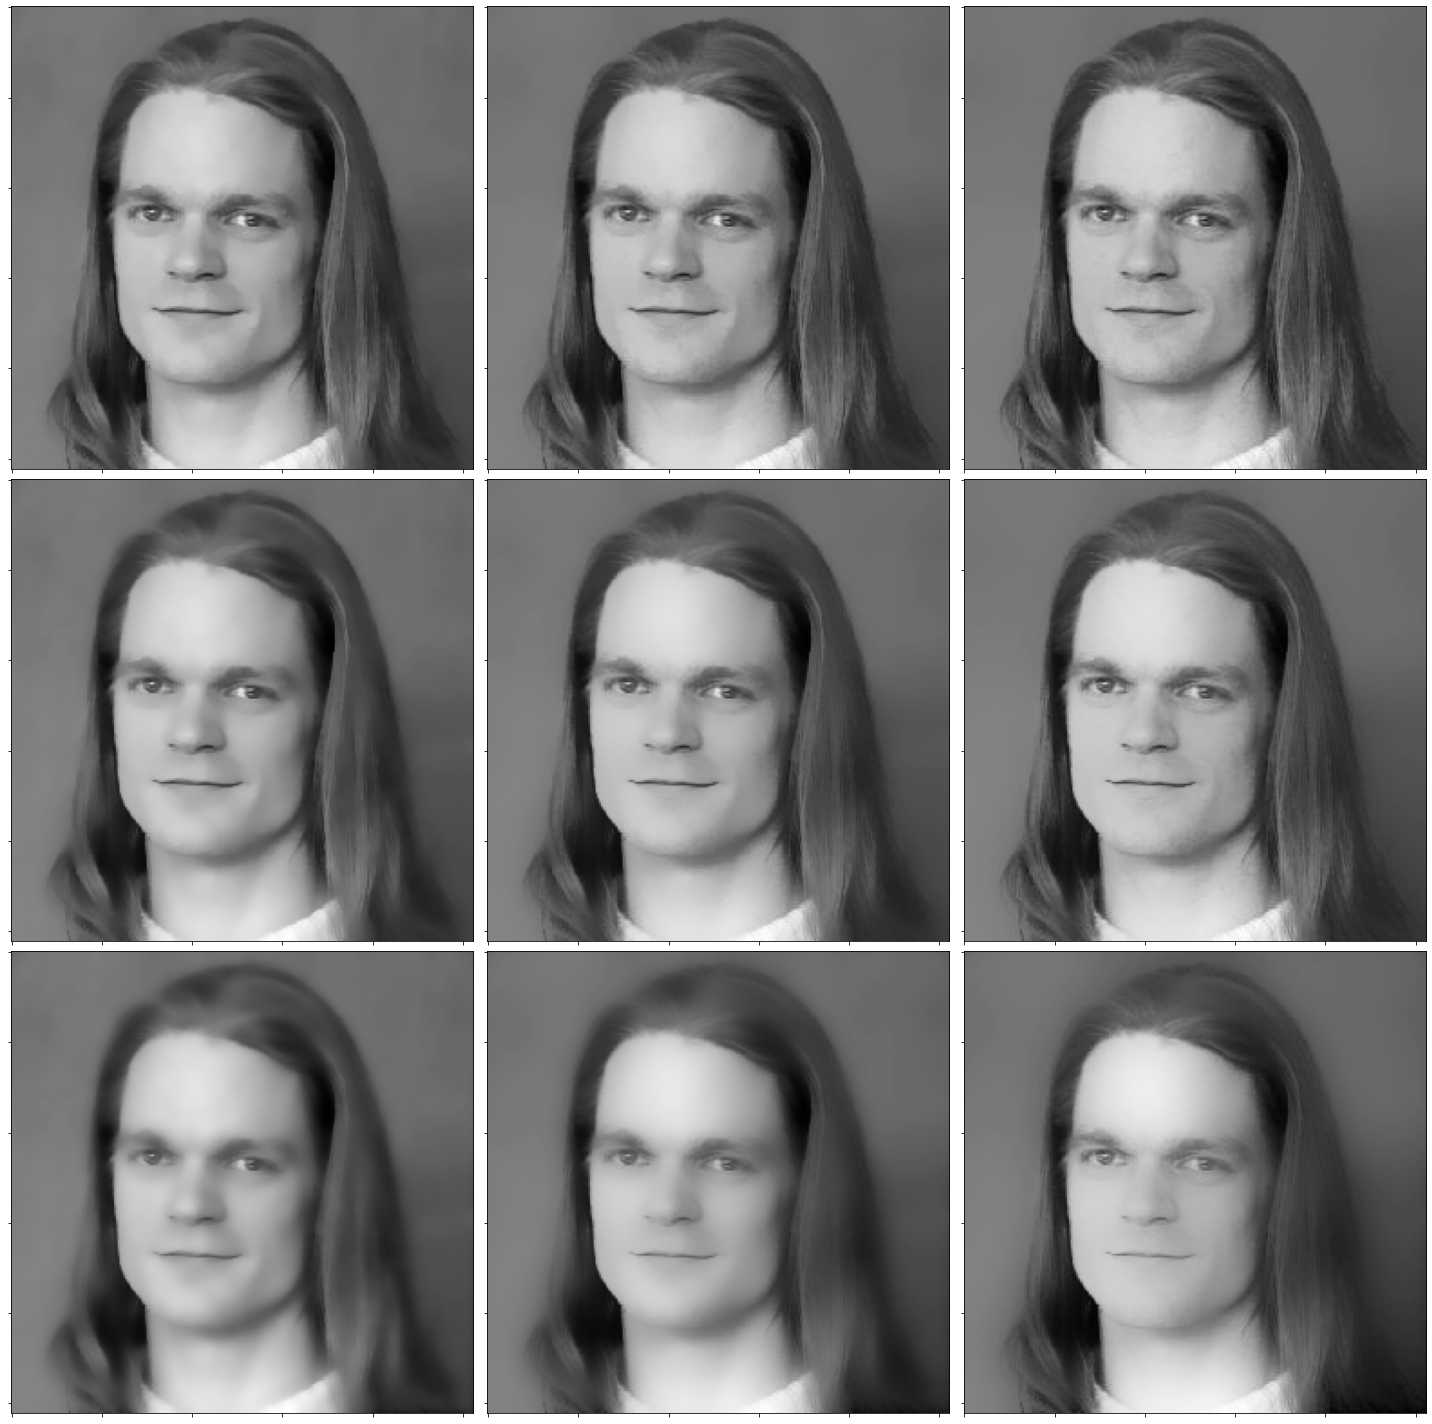

In [ ]:
arrF = imageRead('portrait.png')

rhos = [10, 20, 40]
sigmas = [3, 6, 12]

fig, axs = plt.subplots(len(rhos), len(sigmas), figsize=(20,20))

for r, rho in enumerate(rhos):
    for c, sig in enumerate(sigmas):
        ax = axs[r][c]
        arrH = bilateral_filter(arrF, rho, sig)
        ax.imshow(arrH, cmap='gray')
        
        ax.set_xticklabels([]); ax.set_yticklabels([])    
        fig.tight_layout()

## 4 - More bilateral filtering

Bilateral filters allow for interesting stylized image effects when they are applied repeatedly. For instance, the script:

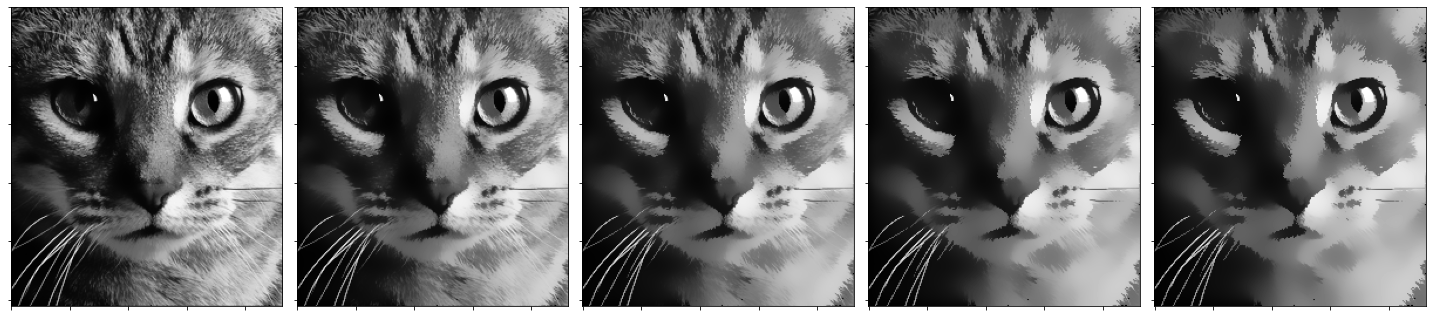

In [ ]:
arrF = imageRead('cat.png')
images = [arrF]

for i in range(5):
    images.append(bilateral_filter(images[-1], rho=20, sig=5))

plotImagesAsRow(images[1:])

Load image `portrait.png` into array `arrF` and run the above script with your implementation of the bilateral filter.

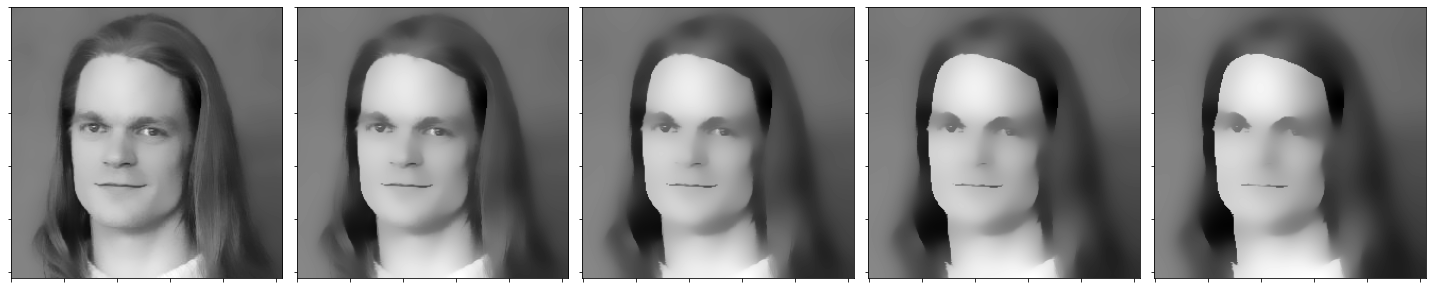

In [ ]:
arrF = imageRead('portrait.png')
images = [arrF]

for i in range(5):
    images.append(bilateral_filter(images[-1], rho=20, sig=5))

plotImagesAsRow(images[1:])

## 5 - Deriche's recursive Gaussian filter

The following function wraps scipy ’s `ndimage` function `gaussian filter` which implements a Gaussian filter.

In [ ]:
def scipy_gaussian_filter(f, sigma):
    return img.gaussian_filter(f, sigma=sigma, mode='constant')

If you load image `cat.png` into array `arrF` to compute:

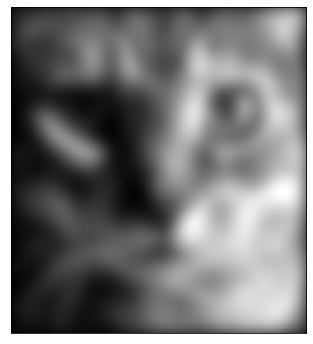

In [ ]:
arrF = imageRead('cat.png')
arrH = scipy_gaussian_filter(arrF, sigma=7.)

plt.imshow(arrH, cmap='gray')
plt.xticks([]); plt.yticks([])
plt.show()

In lecture 18, we discussed the following implementation of Deriche’s recursive 2D Gaussian filter.

What we did not discuss in that lecture are the implementation details of function `computeCoefficients` which computes four 1D arrays `ap`, `am`, `bp`, and `bm` of filter coefficients. Implementing this function is your job in this task.

We therefore recall that, given the standard deviation σ of an isotropic Gaussian kernel, the coefficients of the respective causal filter can be computed as:

\begin{align}
  a_0^+ = & \; \alpha_1 + \alpha_2 \\[1ex]
  a_1^+ = & \; e^{-\frac{\gamma_2}{\sigma}} \left( \beta_2 \sin\frac{\omega_2}{\sigma}-(\alpha_2+2 \alpha_1) \cos\frac{\omega_2}{\sigma} \right) + 
               e^{-\frac{\gamma_1}{\sigma}} \left( \beta_1 \sin\frac{\omega_1}{\sigma}-(2 \alpha_2+\alpha_1) \cos\frac{\omega_1}{\sigma} \right) \\[1ex]
  a_2^+ = & \; 2 e^{-\frac{\gamma_1+\gamma_2}{\sigma}}   
  				\left( 
  				(\alpha_1+\alpha_2) \cos\frac{\omega_2}{\sigma} \cos\frac{\omega_1}{\sigma}
				- \cos\frac{\omega_2}{\sigma} \beta_1 \sin\frac{\omega_1}{\sigma}
				- \cos\frac{\omega_1}{\sigma} \beta_2 \sin\frac{\omega_2}{\sigma}
				\right) \\[1ex]
    	  & \; + \alpha_2 e^{-2 \frac{\gamma_1}{\sigma}} + \alpha_1 e^{-2 \frac{\gamma_2}{\sigma}} \\[1ex]
  a_3^+ = & \; e^{-\frac{\gamma_2 + 2 \gamma_1}{\sigma}}  \left(\beta_2 \sin\frac{\omega_2}{\sigma}-\alpha_2 \cos\frac{\omega_2}{\sigma}\right)
             + e^{-\frac{\gamma_1 + 2 \gamma_2}{\sigma}}  \left(\beta_1 \sin\frac{\omega_1}{\sigma}-\alpha_1 \cos\frac{\omega_1}{\sigma}\right) \\[1ex]         
  b_1^+ = & \; -2 e^{-\frac{\gamma_2}{\sigma}} \cos\frac{\omega_2}{\sigma} - 2 e^{-\frac{\gamma_1}{\sigma}} \cos\frac{\omega_1}{\sigma} \\[1ex]
  b_2^+ = & \; 4 \cos\frac{\omega_2}{\sigma} \cos\frac{\omega_1}{\sigma} e^{-\frac{\gamma_1 + \gamma_2}{\sigma}}
               + e^{-2 \frac{\gamma_2}{\sigma}} + e^{-2 \frac{\gamma_1}{\sigma}} \\[1ex]
  b_3^+ = & \; -2 \cos\frac{\omega_1}{\sigma} e^{-\frac{\gamma_1 + 2 \gamma_2}{\sigma}}
    - 2 \cos\frac{\omega_2}{\sigma} e^{-\frac{\gamma_2 + 2 \gamma_1}{\sigma}} \\[1ex]
  b_4^+ = & \; e^{-\frac{2 \gamma_1 + 2 \gamma_2}{\sigma}}             
\end{align}

where the parameters $\alpha_i, \beta_i, \gamma_i, \omega_i$ are given according to the following table

 |  $\alpha_i$ | $\beta_i$ | $\gamma_i$ | $\omega_i$ 
---------------|-----------|---------|--------|
| $i = 1$      | 1.6800    |  3.7350 | 1.7830 | 0.6318
| $i = 2$ | -0.6803 | -0.2598 | 1.7230 | 1.9970

Implement the function `computeCoefficients` such that it returns the coefficients $a_m^+$ in array `ap` and the coefficients $b_m^+$ in array `bp`.

Also, recall that, once the causal filter coefficients $a_m^+$ and $b_m^+$ have been computed, the coefficient of the respective anti-causal filter can be computed according to
\begin{align*}
b_m^- & = b_m^+  \quad \forall m\\ 
a_1^- & = a_1^+ - b_1^+ a_0^+ \\
a_2^- & = a_2^+ - b_2^+ a_0^+ \\
a_3^- & = a_3^+ - b_3^+ a_0^+ \\
a_4^- & =       - b_4^+ a_0^+
\end{align*}

In [ ]:
def computeCoefficients(sigma):
    a1, b1, g1, o1 =  1.6800,  3.7350, 1.7830, 0.6318
    a2, b2, g2, o2 = -0.6803, -0.2598, 1.7230, 1.9970

    a0p = a1 + a2
    a1p = exp(-g2/sigma) * (b2*sin(o2/sigma)-(a2+2*a1)*cos(o2/sigma))+ \
          exp(-g1/sigma) * (b1*sin(o1/sigma)-(2*a2+a1)*cos(o1/sigma))
    a2p = 2*exp(-(g1+g2)/sigma) * ((a1+a2)*cos(o2/sigma)*cos(o1/sigma) -
                                   cos(o2/sigma)*b1*sin(o1/sigma) -
                                   cos(o1/sigma)*b2*sin(o2/sigma)) + \
                                   a2*exp(-2*g1/sigma) + a1*exp(-2*g2/sigma)
    a3p = exp(-(g2+2*g1)/sigma) * (b2*sin(o2/sigma)-a2*cos(o2/sigma)) + \
          exp(-(g1+2*g2)/sigma) * (b1*sin(o1/sigma)-a1*cos(o1/sigma))
    b1p = -2*exp(-g2/sigma)*cos(o2/sigma) - 2*exp(-g1/sigma)*cos(o1/sigma)
    b2p = 4*cos(o2/sigma)*cos(o1/sigma) * exp(-(g1+g2)/sigma) + \
          exp(-2*g2/sigma) + exp(-2*g1/sigma)
    b3p = -2*cos(o1/sigma) * exp(-(g1+2*g2)/sigma) - \
          2*cos(o2/sigma) * exp(-(g2+2*g1)/sigma)
    b4p = exp(-2*(g1+g2)/sigma)

    a1m = a1p - b1p * a0p
    a2m = a2p - b2p * a0p
    a3m = a3p - b3p * a0p
    a4m =     - b4p * a0p
    b1m = b1p
    b2m = b2p
    b3m = b3p
    b4m = b4p

    ap = np.array([a0p, a1p, a2p, a3p])
    am = np.array([a1m, a2m, a3m, a4m])
    bp = np.array([b1p, b2p, b3p, b4p])
    bm = np.array([b1m, b2m, b3m, b4m])

    return ap, am, bp, bm

In [ ]:
def deriche_gaussian_filter(f, sigma):
    def filter_rows(x):
        # Causal:
        xlr = np.copy(x)
        yp = sig.lfilter(np.hstack((ap,0)),np.hstack((1,bp)),xlr[:,m:-m],axis=1)
        # Anti-causal:
        xrl = np.fliplr(x)
        ym = sig.lfilter(np.hstack((0,am)),np.hstack((1,bm)),xrl[:,m:-m],axis=1)
        ym = np.fliplr(ym)
        return (yp+ym) / (sigma * np.sqrt(2*np.pi))

    ap, am, bp, bm = computeCoefficients(sigma)

    m = 4
    F = np.pad(f, [m,m], mode='constant')
    
    G = filter_rows(F)
    H = filter_rows(G.T)
    return H.T

Once you have implemented function `computeCoefficients`, you can practically work with `deriche_gaussian_filter`.

To see how it behaves, load image `cat.png` into array `arrF` and compute:

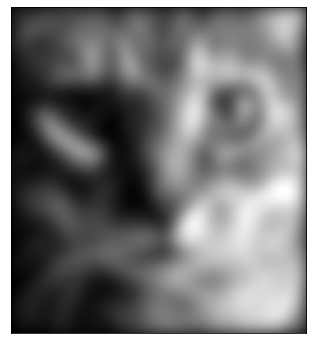

In [ ]:
arrF = imageRead('cat.png')
arrH = deriche_gaussian_filter(arrF, sigma=7.)

plt.imshow(arrH, cmap='gray')
plt.xticks([]); plt.yticks([])
plt.show()

## 6 - Timing Deriche's recursive Gaussian filter

To see what the tedious coding exercise in the previous task will buy you
in practice, perform runtime measurements similar to those in task 2 and
complete the following table:

<table>
    <thead>      
       <tr>
        <th>Name</th>
        <th colspan="4"><center>Filter mask sizes and runtimes [ms]</center></th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td></td>
        <td>&#963;=6</td>
        <td>&#963;=12</td>        
        <td>&#963;=24</td>
        <td>&#963;=48</td>
      </tr>
      <tr>
        <td>scipy_gaussian_filter</td>
        <td>3.71</td>
        <td>7.60</td>        
        <td>16.57</td>
        <td>34.38</td>
      </tr>
      <tr>
        <td>deriche_gaussian_filter</td>
        <td>3.11</td>
        <td>3.22</td>        
        <td>3.15</td>
        <td>3.17</td>
      </tr>
    </tbody>
  </table>

In [ ]:
nRep =   3
nRun = 100
    
for sigma in [6, 12, 24, 48]:
    # Time the scipy gaussian filter.
    fct = scipy_gaussian_filter
    ts = timeit.Timer(functools.partial(fct,arrF,sigma)).repeat(nRep, nRun)
    print(f"Scipy_gaussian_filter(arrF, {sigma}) took\t{np.round((min(ts) / nRun), 5)}\t sec.")

    # Time the deriche gaussian filter.
    fct = deriche_gaussian_filter
    ts = timeit.Timer(functools.partial(fct,arrF,sigma)).repeat(nRep, nRun)
    print(f"Deriche_gaussian_filter(arrF, {sigma}) took\t{np.round((min(ts) / nRun), 5)}\t sec.")
    print()

Scipy_gaussian_filter(arrF, 6) took	0.00371	 sec.
Deriche_gaussian_filter(arrF, 6) took	0.00311	 sec.

Scipy_gaussian_filter(arrF, 12) took	0.0076	 sec.
Deriche_gaussian_filter(arrF, 12) took	0.00322	 sec.

Scipy_gaussian_filter(arrF, 24) took	0.01657	 sec.
Deriche_gaussian_filter(arrF, 24) took	0.00315	 sec.

Scipy_gaussian_filter(arrF, 48) took	0.03438	 sec.
Deriche_gaussian_filter(arrF, 48) took	0.00317	 sec.



Notice, that the runntimes of the `deriche_gaussian_filter` seem to be in $\mathcal{O}(1)$! Which is a huge advantage over the `scipy_gaussian_filter` with exponential runtime.